In [67]:
import re
import time
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


# download stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/awmarcel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awmarcel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/awmarcel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Functions
def convert_json_to_pandas(file_path: str) -> pd.DataFrame:
    with open(file_path, 'r') as f:
        data = json.load(f) 
        return pd.json_normalize(data)

In [63]:
# Load data:
df = convert_json_to_pandas('../data/raw/complaints-2021-05-14_08_16_.json')

# Rename columns:
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code',
    'complaint_id', 'issue', 'date_received', 'state', 
    'consumer_disputed', 'product', 'company_response', 
    'company', 'submitted_via', 'date_sent_to_company', 
    'company_public_response', 'sub_product', 'timely',
    'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'
]

# Handle missing values:
df['complaint_what_happened'] = df['complaint_what_happened'].fillna(np.nan)
df = df[df.consumer_consent_provided == 'Consent provided'].reset_index(drop=True)

In [64]:
lemmatizer = WordNetLemmatizer()

# Function:
def preprocess_text(text: str, stop_words: list, punctuations: list) -> str:
    # Tokenize text:
    tokens = word_tokenize(text.lower())
    
    # Remove stop words and punctuations:
    filtered_tokens = [
        token
        for token in tokens
        if token not in stop_words and token not in punctuations
    ]

    # Lemmatization:
    lemmatized_tokens = [lemmatizer.lemmatize(token, get) for token in filtered_tokens]
    return " ".join(lemmatized_tokens)

In [65]:
# Prepare stop words and punctuations
stop_words = stopwords.words("english")
punctuations = string.punctuation

# Text preprocessing:
df['complaint_what_happened'] = df['complaint_what_happened'].str.lower()
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'[^\w\s]', '', regex=True)
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\b\w*\d\w*\b', '', regex=True)
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'x{1,}', '', regex=True)
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\s+', ' ', regex=True)

start = time.perf_counter()
texts = df['complaint_what_happened'].tolist()
cleaned_texts = [preprocess_text(text, stop_words, punctuations) for text in texts]
end = time.perf_counter()
print(f"Text preprocessing took: {end-start:.1f} s")

Text preprocessing took: 23.3 s


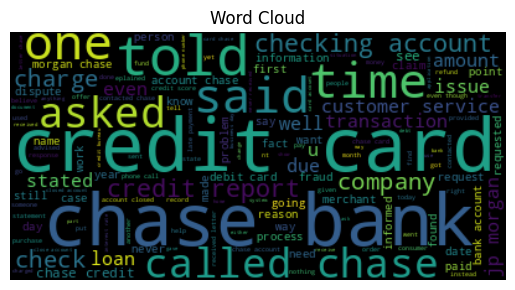

In [66]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(cleaned_texts))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud")
plt.axis("off")
plt.show()